In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageFile
from torch.utils.data import Subset

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)

In [2]:
# Define dataset path
data_dir = '/kaggle/input/ai-generated-images-vs-real-images/train'



Image.MAX_IMAGE_PIXELS = None  
# or
Image.MAX_IMAGE_PIXELS = 200000000  


def convert_to_rgb(image):
    if image.mode == 'P':  
        image = image.convert("RGBA")  
    if image.mode == "RGBA":  
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB") 
    return image



def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)  
    return image


train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),  
    transforms.Lambda(convert_to_rgb),               
    transforms.RandomResizedCrop(224),               
    transforms.RandomHorizontalFlip(p=0.5),          
    transforms.RandomVerticalFlip(p=0.2),            
    transforms.RandomRotation(degrees=15),           
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])



val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),             
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])


ImageFile.LOAD_TRUNCATED_IMAGES = True


MIN_IMAGE_FILE_SIZE = 3284  


def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        
        with Image.open(file_path) as img:
            img.verify()  
        return True
    except (OSError, Image.DecompressionBombError):
        return False


class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]


dataset = ValidImageFolder(root=data_dir, transform=train_transform)

In [3]:
fake_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['fake']]
real_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['real']]


fake_subset_size = int(0.5 * len(fake_indices))
real_subset_size = int(0.5 * len(real_indices))

fake_subset_indices = fake_indices[:fake_subset_size]  
real_subset_indices = real_indices[:real_subset_size]  

balanced_subset_indices = np.concatenate((fake_subset_indices, real_subset_indices))

balanced_subset = Subset(dataset, balanced_subset_indices)

print(f"Original Dataset Size: {len(dataset)}")
print(f"Balanced Subset Size: {len(balanced_subset)} (Fake: {fake_subset_size}, Real: {real_subset_size})")

Original Dataset Size: 47998
Balanced Subset Size: 23999 (Fake: 12000, Real: 11999)


In [4]:
train_size = int(0.8 * len(balanced_subset))
val_size = len(balanced_subset) - train_size
train_dataset, val_dataset = random_split(balanced_subset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [5]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 19199
Validation Dataset Size: 4800


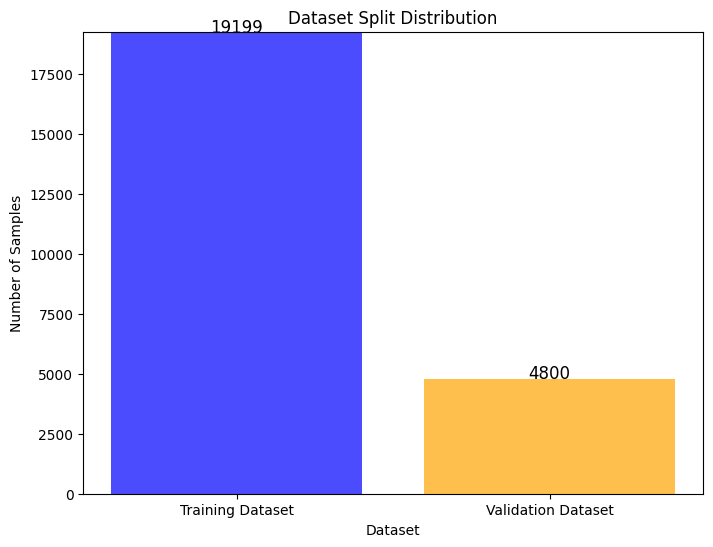

In [6]:
train_size = len(train_dataset)
val_size = len(val_dataset)

labels = ['Training Dataset', 'Validation Dataset']
sizes = [train_size, val_size]

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['blue', 'orange'], alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 5, str(size), ha='center', fontsize=12)

plt.title('Dataset Split Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.ylim(0, max(sizes) + 50)
plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
from torchvision.models import resnet18
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  
    nn.Linear(num_ftrs, 2)  
)


model = model.to(device)

model.load_state_dict(torch.load('/kaggle/input/resnet-18-trained-first-half-of-data-training/pytorch/default/1/best_model6for_RESNET18_After_First_Half_training_part.pth', map_location=device))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]
<ipython-input-8-1651b3b4e058>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possi

<All keys matched successfully>

In [9]:

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
patience = 5
trigger_times = 0
best_val_loss = float('inf')

In [11]:
epochs = 9
best_val_acc = 0.0

# data={
#     "train_losses" : [],
#     "train_accuracies" : [],
#     "val_losses" : [],
#     "val_accuracies" : [],
# }

In [12]:
df = pd.read_csv("/kaggle/input/results-resnet18-in-first-half-of-data/ResNet18_scorse_after_first_half.csv")

data = df.to_dict(orient="list")

print(data)

{'train_losses': [0.4855372396209127, 0.3682176784768292, 0.3306304836057115, 0.2929833247528839, 0.2687830820053317, 0.2535709523677801, 0.250118053081607, 0.2425399298416189, 0.2450099952010178], 'train_accuracies': [0.7836345643002239, 0.8422313662169905, 0.8582217823844992, 0.8774415334131986, 0.8875462263659566, 0.8948382728267097, 0.8958279077035262, 0.896661284441898, 0.897546747226418], 'val_losses': [0.5067116602261861, 0.57057230869929, 0.3936219576994578, 0.2933284978071848, 0.2702813220024109, 0.2739295939604441, 0.2670359571774801, 0.2697976722319921, 0.2701718248923619], 'val_accuracies': [0.7814583333333334, 0.7097916666666667, 0.8275, 0.8745833333333334, 0.8839583333333334, 0.8854166666666667, 0.8925000000000001, 0.8885416666666667, 0.89]}


In [13]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    data["train_losses"].append(epoch_loss)
    data["train_accuracies"].append(epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    data["val_losses"].append(val_loss)
    data["val_accuracies"].append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model{epoch}for_RESNET18_After_Seconed_Half_training_part.pth')
        trigger_times = 0  # Reset early stopping counter
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping...")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Best Validation loss: {best_val_loss:.4f}')

Epoch 1/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3870 Acc: 0.8368
Val Loss: 0.3668 Acc: 0.8433

Classification Report:
              precision    recall  f1-score   support

        fake       0.88      0.79      0.83      2375
        real       0.82      0.89      0.85      2425

    accuracy                           0.84      4800
   macro avg       0.85      0.84      0.84      4800
weighted avg       0.85      0.84      0.84      4800

Epoch 2/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3420 Acc: 0.8560
Val Loss: 0.3553 Acc: 0.8473

Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.88      0.85      2375
        real       0.87      0.82      0.84      2425

    accuracy                           0.85      4800
   macro avg       0.85      0.85      0.85      4800
weighted avg       0.85      0.85      0.85      4800

Epoch 3/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3180 Acc: 0.8640
Val Loss: 0.4104 Acc: 0.8298

Classification Report:
              precision    recall  f1-score   support

        fake       0.87      0.77      0.82      2375
        real       0.80      0.88      0.84      2425

    accuracy                           0.83      4800
   macro avg       0.83      0.83      0.83      4800
weighted avg       0.83      0.83      0.83      4800

Early stopping trigger count: 1/5
Epoch 4/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2843 Acc: 0.8813
Val Loss: 0.2847 Acc: 0.8815

Classification Report:
              precision    recall  f1-score   support

        fake       0.87      0.89      0.88      2375
        real       0.89      0.87      0.88      2425

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.88      4800
weighted avg       0.88      0.88      0.88      4800

Epoch 5/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2547 Acc: 0.8955
Val Loss: 0.2809 Acc: 0.8783

Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.81      0.87      2375
        real       0.84      0.94      0.89      2425

    accuracy                           0.88      4800
   macro avg       0.88      0.88      0.88      4800
weighted avg       0.88      0.88      0.88      4800

Epoch 6/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2469 Acc: 0.8991
Val Loss: 0.2508 Acc: 0.8973

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.89      0.90      2375
        real       0.89      0.91      0.90      2425

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Epoch 7/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2384 Acc: 0.9016
Val Loss: 0.2523 Acc: 0.8900

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.88      0.89      2375
        real       0.88      0.90      0.89      2425

    accuracy                           0.89      4800
   macro avg       0.89      0.89      0.89      4800
weighted avg       0.89      0.89      0.89      4800

Early stopping trigger count: 1/5
Epoch 8/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2362 Acc: 0.9021
Val Loss: 0.2504 Acc: 0.8967

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.89      0.89      2375
        real       0.89      0.90      0.90      2425

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Epoch 9/9


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2366 Acc: 0.9017
Val Loss: 0.2515 Acc: 0.8979

Classification Report:
              precision    recall  f1-score   support

        fake       0.91      0.88      0.90      2375
        real       0.89      0.91      0.90      2425

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Early stopping trigger count: 1/5
Best Validation Accuracy: 0.8979
Best Validation loss: 0.2504


In [14]:
df = pd.DataFrame(data)


In [15]:
data


{'train_losses': [0.4855372396209127,
  0.3682176784768292,
  0.3306304836057115,
  0.2929833247528839,
  0.2687830820053317,
  0.2535709523677801,
  0.250118053081607,
  0.2425399298416189,
  0.2450099952010178,
  0.3869541666117663,
  0.34199798609001003,
  0.31803996907937615,
  0.284335061781257,
  0.2547471367373393,
  0.2468786869106693,
  0.238422477787544,
  0.23616092337861125,
  0.23657505798882522],
 'train_accuracies': [0.7836345643002239,
  0.8422313662169905,
  0.8582217823844992,
  0.8774415334131986,
  0.8875462263659566,
  0.8948382728267097,
  0.8958279077035262,
  0.896661284441898,
  0.897546747226418,
  0.8368144174175738,
  0.8560341684462732,
  0.8640033335069535,
  0.8812959008281681,
  0.8955153914266368,
  0.8990572425647169,
  0.9015573727798323,
  0.9020782332413146,
  0.9016615448721287],
 'val_losses': [0.5067116602261861,
  0.57057230869929,
  0.3936219576994578,
  0.2933284978071848,
  0.2702813220024109,
  0.2739295939604441,
  0.2670359571774801,
  0.2

In [16]:
df

,train_losses,train_accuracies,val_losses,val_accuracies
0,0.485537,0.783635,0.506712,0.781458
1,0.368218,0.842231,0.570572,0.709792
2,0.330630,0.858222,0.393622,0.827500
3,0.292983,0.877442,0.293328,0.874583
4,0.268783,0.887546,0.270281,0.883958
5,0.253571,0.894838,0.273930,0.885417
6,0.250118,0.895828,0.267036,0.892500
7,0.242540,0.896661,0.269798,0.888542
8,0.245010,0.897547,0.270172,0.890000
9,0.386954,0.836814,0.366797,0.843333


In [17]:
df.to_csv("/kaggle/working/ResNet18_scorse_after_Second_half.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


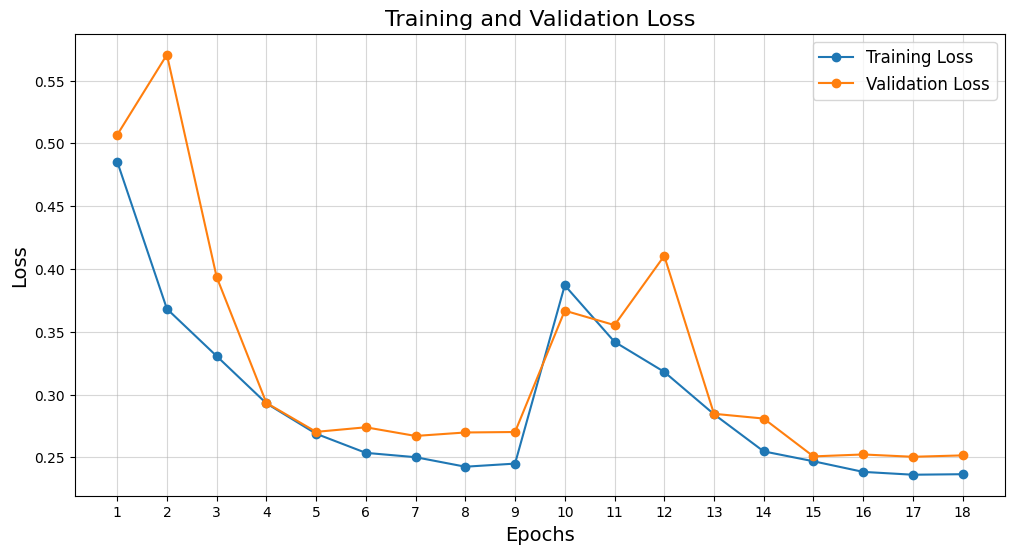

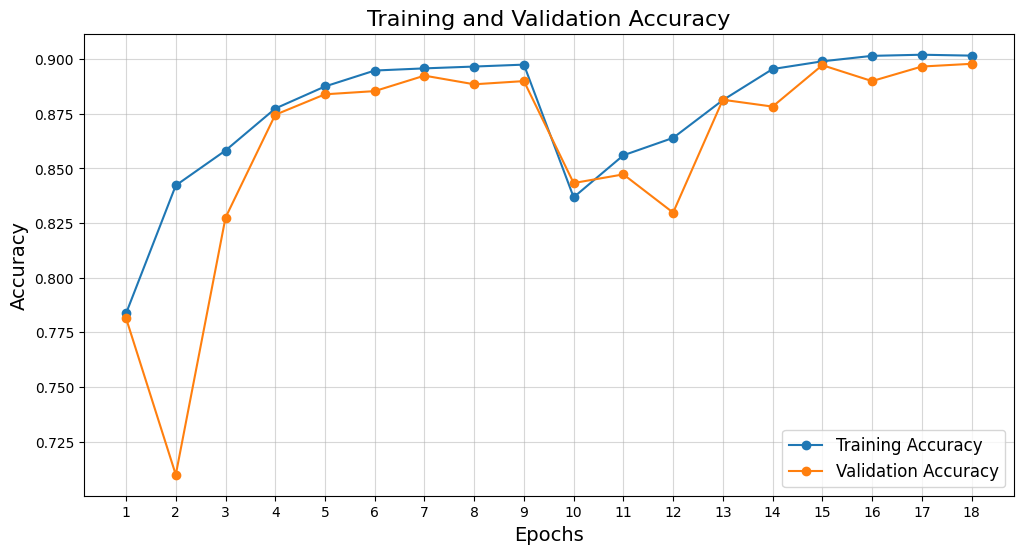

In [18]:

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_losses"]) + 1), data["train_losses"], label='Training Loss', marker='o')
plt.plot(range(1, len(data["val_losses"]) + 1), data["val_losses"], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, len(data["train_losses"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_accuracies"]) + 1), data["train_accuracies"], label='Training Accuracy', marker='o')
plt.plot(range(1, len(data["val_accuracies"]) + 1), data["val_accuracies"], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(data["train_accuracies"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()